##Importing necessary libraries

In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from google.colab import drive
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses,callbacks
from tensorflow.keras.models import *
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from sklearn.metrics import precision_recall_fscore_support
from scipy import stats
import operator
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##Mounting On Google Drive

In [ ]:
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
 Breast_Cancer.ipynb			      resized_lesion2
 BUS2.zip				      resized_lesion_categorized
'Colab Notebooks'			      test.csv
 ISIC-2017_Test_v2_Data			      test_features.csv
 ISIC-2017_Test_v2_Part3_GroundTruth.csv      train.csv
 ISIC-2017_Training_Part3_GroundTruth.csv     train_features.csv
 ISIC-2017_Validation_Part3_GroundTruth.csv   valid.csv
 metrics_plot.png			      valid_features.csv
 resized_lesion


##Functions to load dataset
dataset loaded by image data generator

In [ ]:
def load_data(directory, bs):
  data = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names={'benign', 'malign', 'keratosis'},
    color_mode="rgb",
    batch_size=bs,
    image_size=(224, 224))
  return data

##Base CNN model

In [ ]:
def CNN_model(input_size=(224, 224,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same' )(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(drop1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop2 = Dropout(0.2)(pool2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(drop2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)
    drop3 = Dropout(0.2)(pool3)
    flat1 = Flatten()(drop3)
    fc1 = Dense(512, activation='relu')(flat1)
    drop4 = Dropout(0.2)(fc1)
    output = Dense(3, activation='softmax')(drop4)

    model = Model(inputs=inputs, outputs=output)
    # optim = SGD()
    optim = Adam(lr=0.01)
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

##Function to train the model

In [ ]:
def train_model(model, epoch, train_data, valid_data):
  history = model.fit(train_data,
          epochs=epoch,
          verbose=1, validation_data = valid_data)
  return model, history

##Function to display Train & Validation Accuracy and Losses

In [ ]:
def plot_metrics(history):
  # plot loss
  plt.subplot(1, 2, 1)
  plt.title('Categorical CrossEntropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(["training loss", "validation loss"], loc ="lower right")
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(["training accuracy", "validation accuracy"], loc ="lower right")
  plt.savefig('/content/gdrive/MyDrive/metrics_plot.png')
  plt.show()
  plt.close()

Conversion from generator to array

In [ ]:
def test_ary_data(valid_data):
  test_X = []
  test_y = []
  for img, lbl in valid_data:
    img = np.array(img)
    lbl = np.array(lbl)
    for x in range(img.shape[0]):
      norm_img = np.array(img[x])
      test_X.append(norm_img)
      test_y.append(np.argmax(np.array(lbl[x])))
  print("valid_data shape", np.array(test_X).shape, np.array(test_y).shape)
  test_y = np.array(test_y)
  # test_y = np.reshape(test_y, (1, 50))
  return test_X, test_y

##Function to make predictions from trained model

In [ ]:
def make_predictions(trained_model, valid_data):
  total_preds = []
  total_lbls=[]
  for img, lbl in valid_data:
    pred_ary = []
    lbl_ary = []
    test_X = []
    predictions = trained_model.predict(img)
    for i in range (predictions.shape[0]):
      pred = predictions[i]
      lbl_ary.append(np.argmax(np.array(lbl[i])))
      pred_ary.append(np.argmax(pred))
      test_X.append(np.array(img[i]))
    show_preds(np.array(test_X), pred_ary, lbl_ary)
    total_preds = np.concatenate([np.array(total_preds),np.array(pred_ary)])
    total_lbls = np.concatenate([np.array(total_lbls),np.array(lbl_ary)])
  return np.array(total_preds), np.array(total_lbls)



##Function to display predictions

In [ ]:
def show_preds(test_X, preds, lbl_ary):

  for i in range(9):
      plt.subplot(3, 3, i+1)
      if preds[i] == 0:
        tit = "benign"
      elif preds[i] == 1:
        tit = "malign"
      else:
        tit = "keratosis"
      if lbl_ary[i] == preds[i]:
        plt.title(tit, color='blue', fontsize=8, pad=0)
      else:
        plt.title(tit, color='red', fontsize=8, pad=0)
      # plot raw pixel data
      im_sh = np.array(test_X[i]).astype(int)
      plt.imshow(im_sh)
  plt.show()


In [ ]:
def show_images(loaded_data, lbl):
  for i in range(4):
    plt.subplot(2, 2, i+1)
    if np.array(lbl[i]) == 0:
      title = "benign"
    elif np.array(lbl[i]) == 1:
      title = "malign"
    else:
      title = "seborrheic keratosis"
    plt.title(title, color='red', fontsize=8, pad=0)
    # plot raw pixel data
    plt.imshow((np.array(loaded_data[i])).astype(int))

  # show the figure
  plt.show()

#TASK 1: Evaluation of CNN (trained from Scratch)

Found 2000 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_p

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 338s 7s/step - loss: 1024.7316 - accuracy: 0.6315 - val_loss: 1.0316 - val_accuracy: 0.5200
Epoch 2/50
40/40 [==============================] - 4s 90ms/step - loss: 0.8446 - accuracy: 0.6860 - val_loss: 1.1078 - val_accuracy: 0.5200
Epoch 3/50
40/40 [==============================] - 4s 91ms/step - loss: 0.8378 - accuracy: 0.6860 - val_loss: 1.0978 - val_accuracy: 0.5200
Epoch 4/50
40/40 [==============================] - 5s 108ms/step - loss: 0.8377 - accuracy: 0.6860 - val_loss: 1.0992 - val_accuracy: 0.5200
Epoch 5/50
40/40 [==============================] - 4s 88ms/step - loss: 0.8370 - accuracy: 0.6860 - val_loss: 1.0989 - val_accuracy: 0.5200
Epoch 6/50
40/40 [==============================] - 4s 88ms/step - loss: 0.8359 - accuracy: 0.6860 - val_loss: 1.1064 - val_accuracy: 0.5200
Epoch 7/50
40/40 [==============================] - 5s 110ms/step - loss: 0.8377 - accuracy: 0.6860 - val_loss: 1.0951 - val_accuracy: 0.5200
Epoch 8/50
40/40 [=

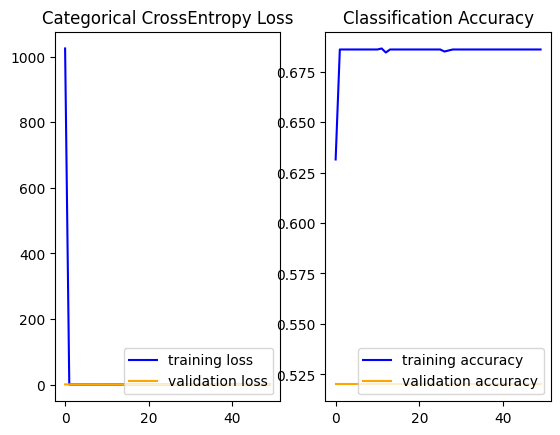

2/2 [==============================] - 0s 138ms/step


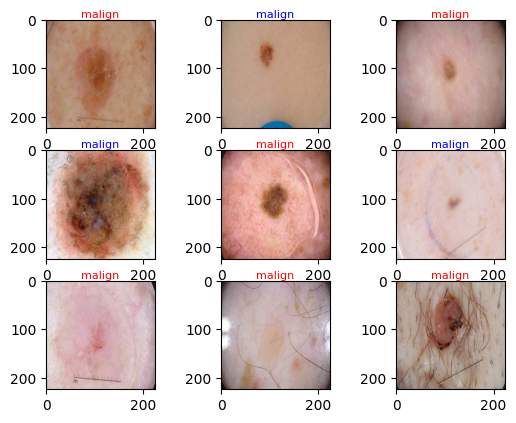

2/2 [==============================] - 0s 15ms/step


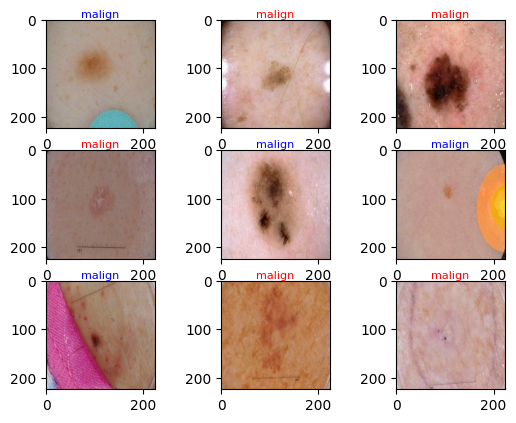

2/2 [==============================] - 0s 11ms/step


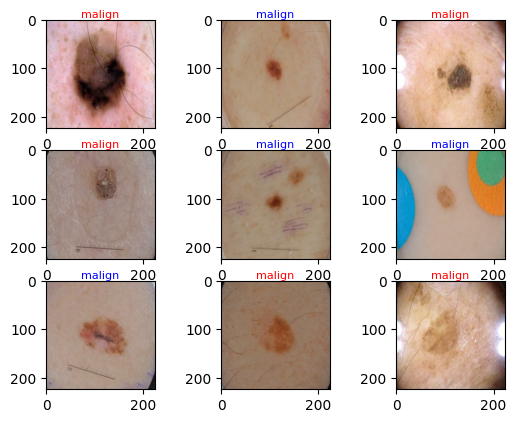

(150,) (150,)
base model accuracy 51.99999809265137
precision, recall, f1, s1 [0. 1. 0.] [0.   0.52 0.  ] [0.         0.68421053 0.        ] [  0 150   0]
precision, recall, f1, s1 0.52 0.52 0.52 None


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 15ms/step


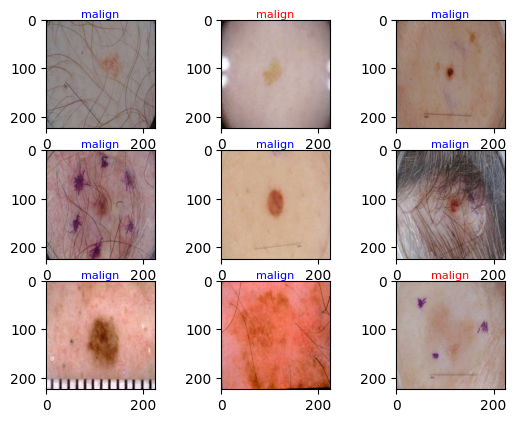

2/2 [==============================] - 0s 13ms/step


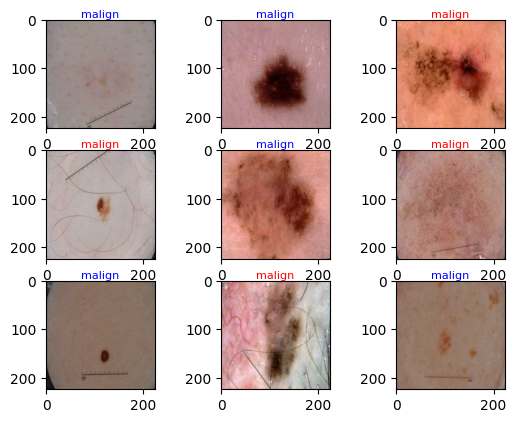

2/2 [==============================] - 0s 19ms/step


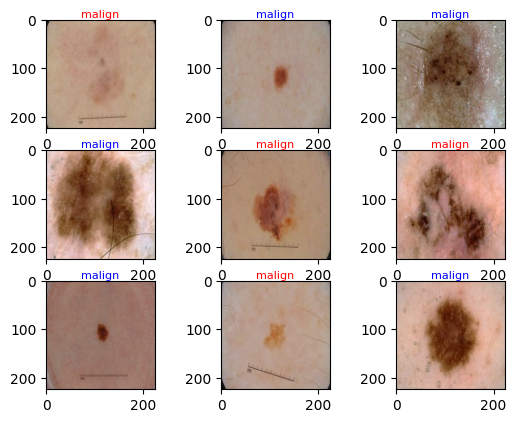

2/2 [==============================] - 0s 14ms/step


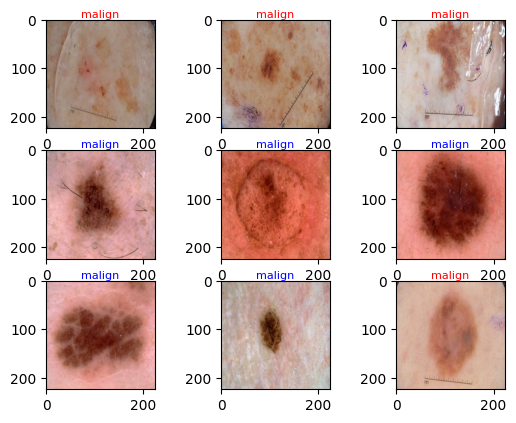

2/2 [==============================] - 0s 19ms/step


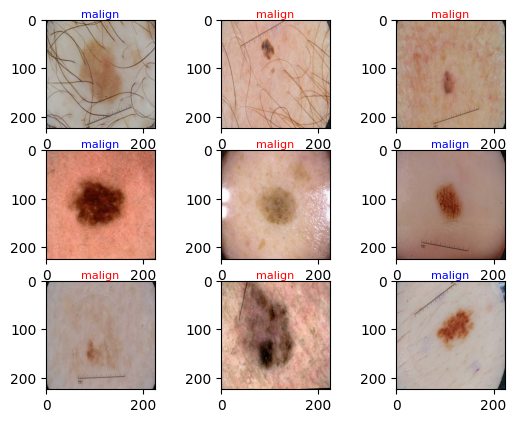

2/2 [==============================] - 0s 12ms/step


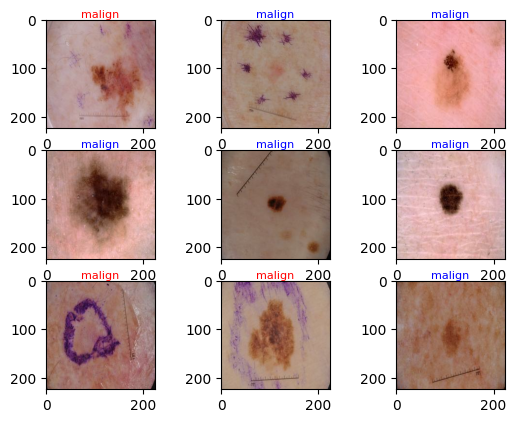

2/2 [==============================] - 0s 15ms/step


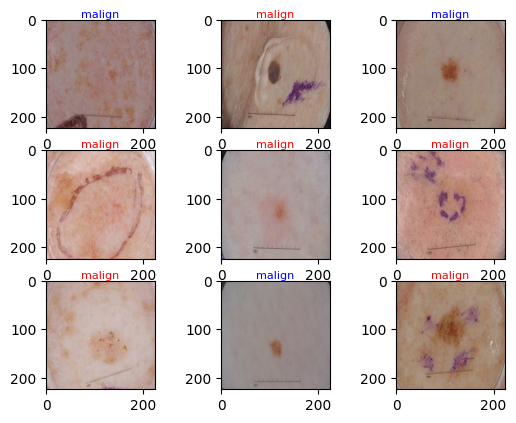

2/2 [==============================] - 0s 14ms/step


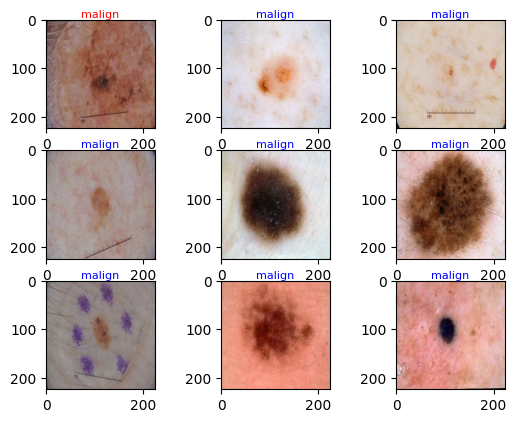

2/2 [==============================] - 0s 11ms/step


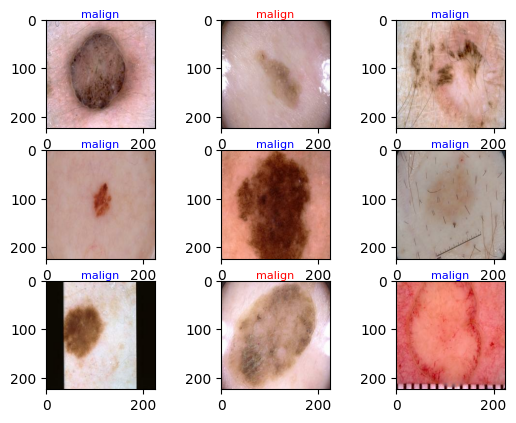

2/2 [==============================] - 0s 16ms/step


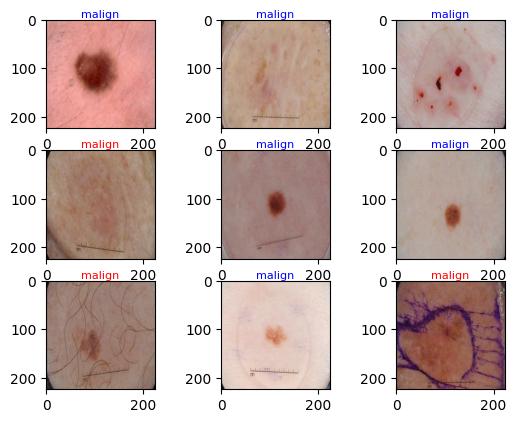

2/2 [==============================] - 0s 15ms/step


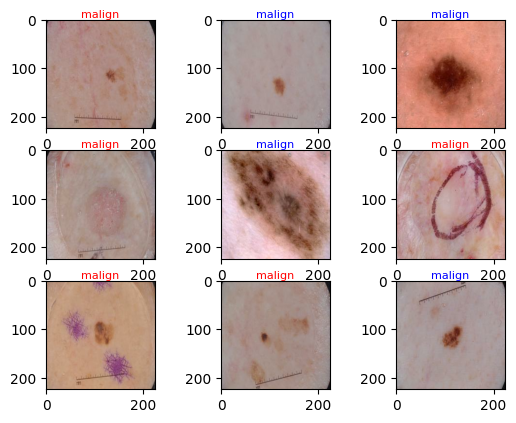

2/2 [==============================] - 0s 15ms/step


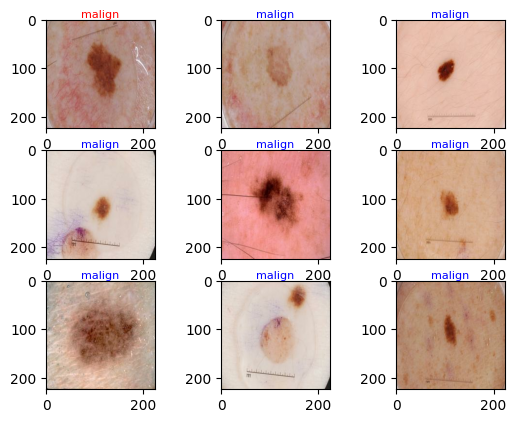

(600,) (600,)
base model accuracy 65.49999713897705
precision, recall, f1, s1 [0. 1. 0.] [0.    0.655 0.   ] [0.         0.79154079 0.        ] [  0 600   0]
precision, recall, f1, s1 0.655 0.655 0.655 None


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_directory = "/content/gdrive/My Drive/resized_lesion_categorized/train/"
valid_directory = "/content/gdrive/My Drive/resized_lesion_categorized/valid/"
test_directory = "/content/gdrive/My Drive/resized_lesion_categorized/test/"
# train_labels_file = pd.read_csv("/content/gdrive/My Drive/train.csv")
# valid_labels_file = pd.read_csv("/content/gdrive/My Drive/valid.csv")

# train_label_ary = np.asarray(train_labels_file["class_label"])
# valid_label_ary = np.asarray(valid_labels_file["class_label"])

train_data = load_data(train_directory, 50)
valid_data = load_data(valid_directory, 50)
test_data = load_data(test_directory, 50)
# for img, lbl in train_data:
#   show_images(img[0:4], lbl[0:4])

# one_hot_encoded_train_data = pd.get_dummies(train_labels_file, columns = ['class_label'])
# one_hot_encoded_valid_data = pd.get_dummies(valid_labels_file, columns = ['class_label'])
# train_lbl = np.asarray(one_hot_encoded_train_data)[:, 1:4]
# valid_lbl = np.asarray(one_hot_encoded_valid_data)[:, 1:4]

model = CNN_model()
trained_model, history = train_model(model, 50, train_data, valid_data)
plot_metrics(history)
predictions, labels = make_predictions(trained_model, valid_data)
print(predictions.shape, labels.shape)
acc = trained_model.evaluate(valid_data, verbose=0)
print("base model accuracy", acc[1]*100)

prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels)
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)


prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels, average="micro")
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)


predictions, labels = make_predictions(trained_model, test_data)
print(predictions.shape, labels.shape)
acc = trained_model.evaluate(test_data, verbose=0)
print("base model accuracy", acc[1]*100)

prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels)
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)


prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels, average="micro")
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)





#Task 2: Evaluating Transfer Learning (ResNet-50)

In [ ]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

Epoch 1/50
40/40 [==============================] - 17s 211ms/step - loss: 1.5039 - accuracy: 0.6535 - val_loss: 1.0529 - val_accuracy: 0.5867
Epoch 2/50
40/40 [==============================] - 7s 166ms/step - loss: 0.4731 - accuracy: 0.8415 - val_loss: 0.9960 - val_accuracy: 0.6533
Epoch 3/50
40/40 [==============================] - 7s 158ms/step - loss: 0.1946 - accuracy: 0.9280 - val_loss: 1.2878 - val_accuracy: 0.6600
Epoch 4/50
40/40 [==============================] - 8s 174ms/step - loss: 0.1113 - accuracy: 0.9590 - val_loss: 1.2609 - val_accuracy: 0.6067
Epoch 5/50
40/40 [==============================] - 8s 172ms/step - loss: 0.0528 - accuracy: 0.9875 - val_loss: 1.2812 - val_accuracy: 0.6533
Epoch 6/50
40/40 [==============================] - 9s 205ms/step - loss: 0.0273 - accuracy: 0.9965 - val_loss: 1.3106 - val_accuracy: 0.6800
Epoch 7/50
40/40 [==============================] - 8s 179ms/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 1.4416 - val_accuracy: 0.6800
Epoch

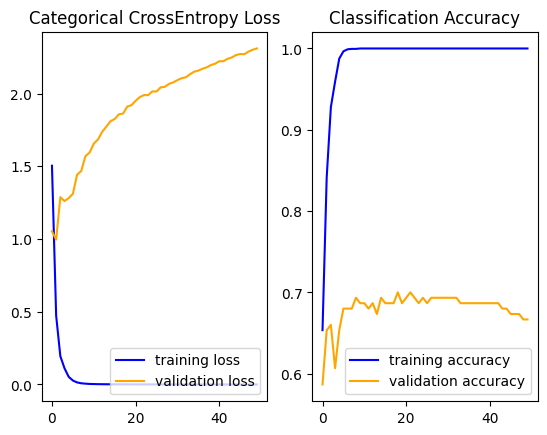

2/2 [==============================] - 3s 874ms/step


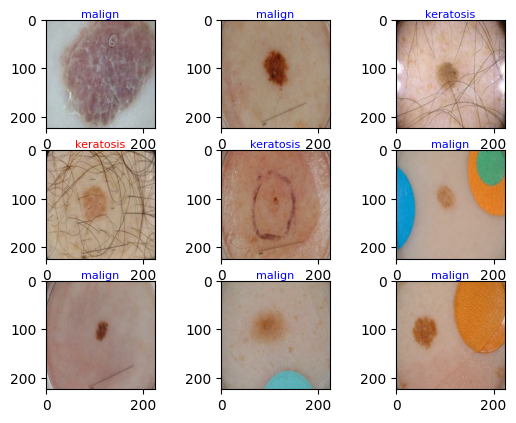

2/2 [==============================] - 0s 146ms/step


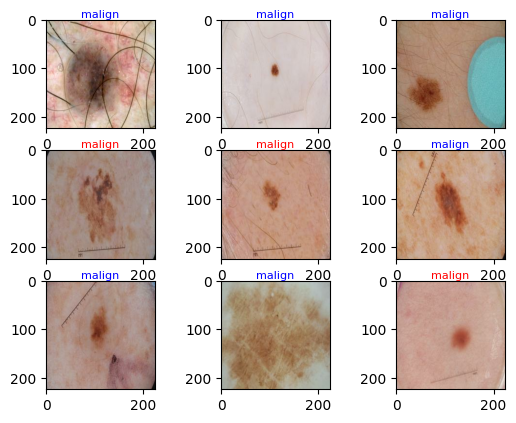

2/2 [==============================] - 0s 128ms/step


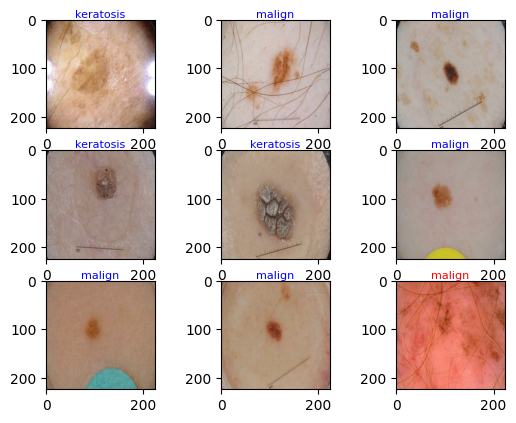

(150,) (150,)
base model accuracy 66.66666865348816
precision, recall, f1, s1 [0.2        0.88461538 0.5952381 ] [0.42857143 0.67647059 0.73529412] [0.27272727 0.76666667 0.65789474] [ 14 102  34]
precision, recall, f1, s1 0.6666666666666666 0.6666666666666666 0.6666666666666666 None
2/2 [==============================] - 0s 93ms/step


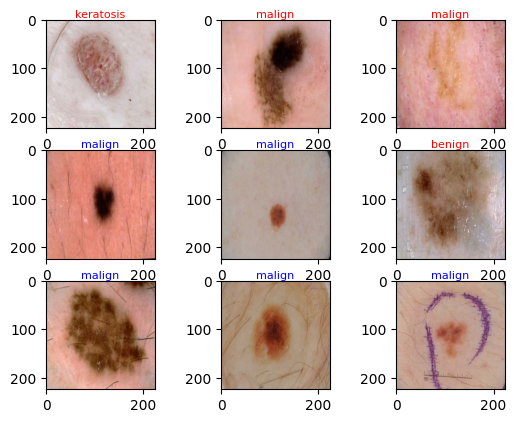

2/2 [==============================] - 0s 119ms/step


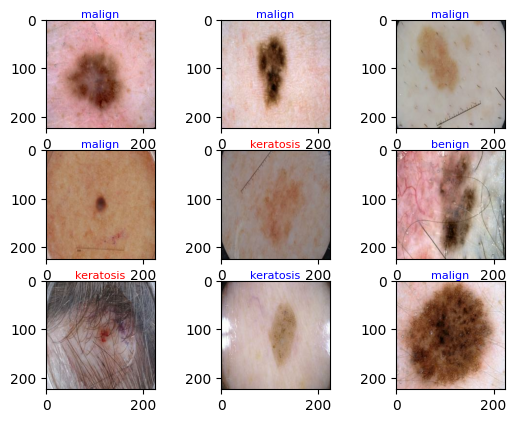

2/2 [==============================] - 0s 111ms/step


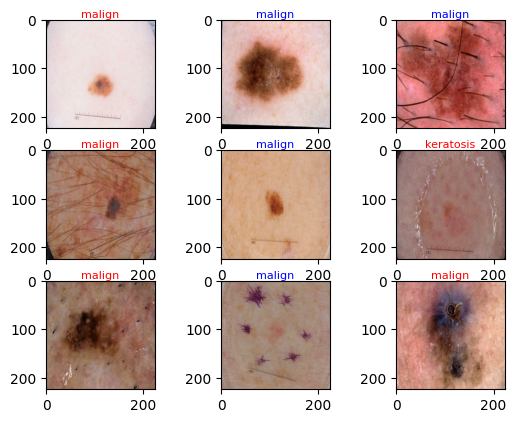

2/2 [==============================] - 0s 82ms/step


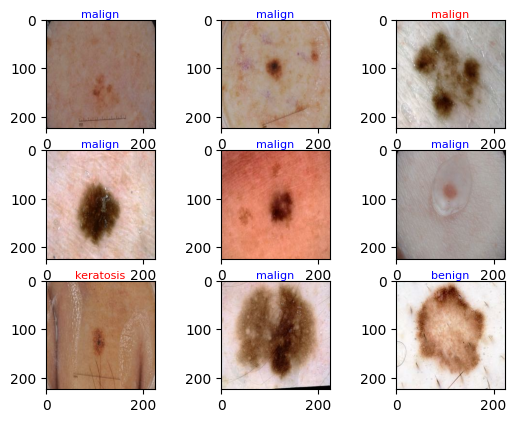

2/2 [==============================] - 0s 132ms/step


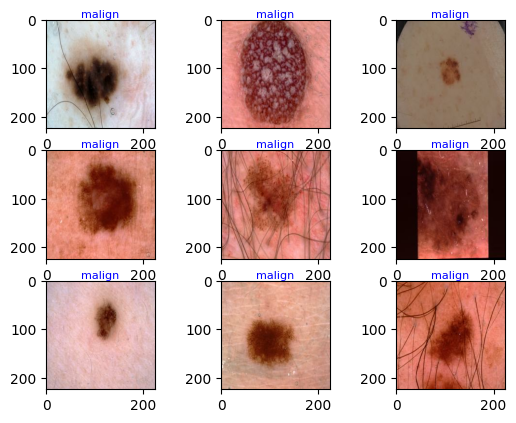

2/2 [==============================] - 0s 121ms/step


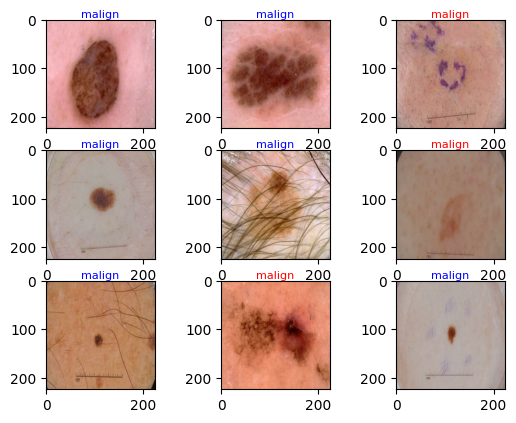

2/2 [==============================] - 0s 120ms/step


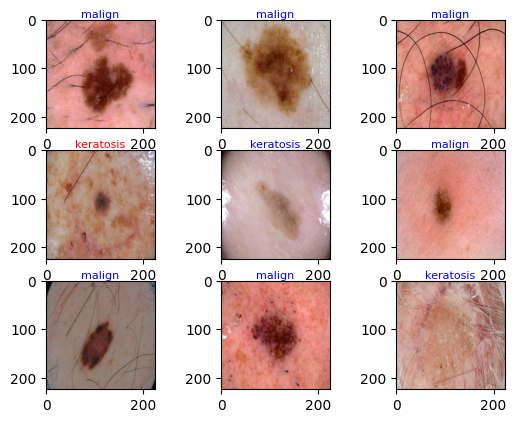

2/2 [==============================] - 0s 125ms/step


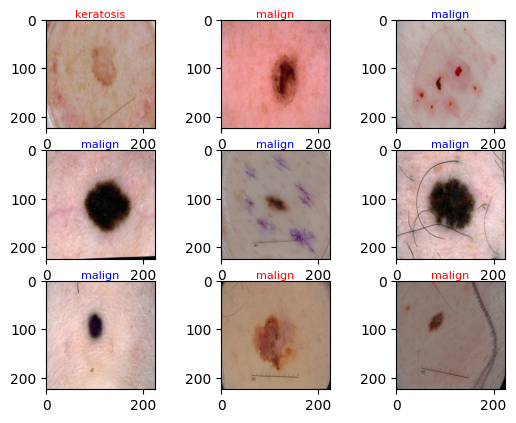

2/2 [==============================] - 0s 166ms/step


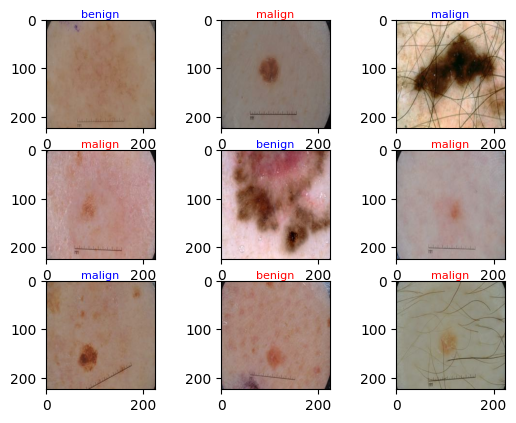

2/2 [==============================] - 0s 129ms/step


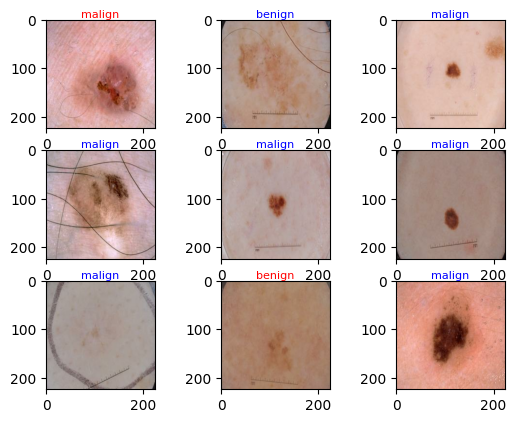

2/2 [==============================] - 0s 134ms/step


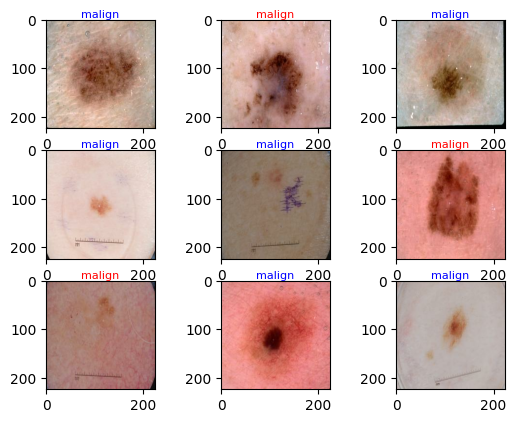

2/2 [==============================] - 0s 128ms/step


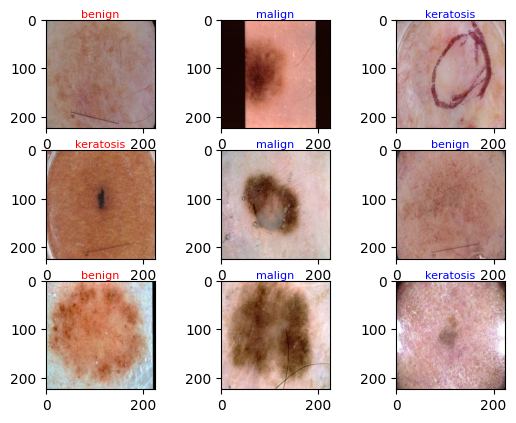

(600,) (600,)
base model accuracy 70.16666531562805
precision, recall, f1, s1 [0.22222222 0.87531807 0.56666667] [0.47272727 0.77477477 0.5049505 ] [0.30232558 0.82198327 0.53403141] [ 55 444 101]
precision, recall, f1, s1 0.7016666666666667 0.7016666666666667 0.7016666666666667 None


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


trained_model, history = train_model(model, 50, train_data, valid_data)
plot_metrics(history)
predictions, labels = make_predictions(trained_model, valid_data)
print(predictions.shape, labels.shape)
acc = trained_model.evaluate(valid_data, verbose=0)
print("base model accuracy", acc[1]*100)

prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels)
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)

prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels, average="micro")
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)


predictions, labels = make_predictions(trained_model, test_data)
print(predictions.shape, labels.shape)
acc = trained_model.evaluate(test_data, verbose=0)
print("base model accuracy", acc[1]*100)

prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels)
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)


prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(predictions, labels, average="micro")
print("precision, recall, f1, s1", prec1, recall1, F1_1, S1_1)



In [ ]:
def evaluate_histogram(img):
  a=np.array(img)
  count ={}
  for i in range(np.array(a).shape[0]):
    for j in range(np.array(a).shape[1]):
        key = a[i][j]
        if key not in count:
            count[key] = 1
        else:
            count[key] = count[key]+1
  min_val = min(count.items(), key=operator.itemgetter(1))[0]
  max_val = max(count.items(), key=operator.itemgetter(1))[0]
  return min_val, max_val


#Task 3: Evaluating machine learning models

#Preparing Dataset of Handcrafted Features for Machine learning model

###Extracting features from train data
(This block needs not to run as we have saved the extracted features in csv file on google drive)

In [ ]:
from numpy.lib.function_base import median
train_dic = {"mean_ch1":[],
             "mean_ch2":[],
             "mean_ch3":[],
             "median_ch1":[],
             "median_ch2":[],
             "median_ch3":[],
             "std_ch1":[],
             "std_ch2":[],
             "std_ch3":[],
             "maxpix_ch1":[],
             "maxpix_ch2":[],
             "maxpix_ch3":[],
             "minpix_ch1":[],
             "minpix_ch2":[],
             "minpix_ch3":[],
             "label":[]}
for img, lbl in train_data:
  for i in range(img.shape[0]):
    loaded_img = img[i]
    means =[]
    medians = []
    stds = []
    max_pixel = []
    min_pixel = []
    for j in range(3):
      img_channel = loaded_img[:, :, j]
      means.append(np.mean(img_channel))
      medians.append(np.median(img_channel))
      stds.append(np.std(img_channel))
      min_val, max_val = evaluate_histogram(img_channel)
      min_pixel.append(min_val)
      max_pixel.append(max_val)
    for x in range(3):
      if x==0:
        train_dic["mean_ch1"].append(means[0])
        train_dic["median_ch1"].append(medians[0])
        train_dic["std_ch1"].append(stds[0])
        train_dic["maxpix_ch1"].append(max_pixel[0])
        train_dic["minpix_ch1"].append(min_pixel[0])
      elif x==1:
        train_dic["mean_ch2"].append(means[1])
        train_dic["median_ch2"].append(medians[1])
        train_dic["std_ch2"].append(stds[1])
        train_dic["maxpix_ch2"].append(max_pixel[1])
        train_dic["minpix_ch2"].append(min_pixel[1])
      elif x==2:
        train_dic["mean_ch3"].append(means[2])
        train_dic["median_ch3"].append(medians[2])
        train_dic["std_ch3"].append(stds[2])
        train_dic["maxpix_ch3"].append(max_pixel[2])
        train_dic["minpix_ch3"].append(min_pixel[2])
    train_dic["label"].append(np.argmax(np.array(lbl[i])))


train_features = pd.DataFrame(train_dic)
train_features

###Extracting features from test data
(This block needs not to run as we have saved the extracted features in csv file on google drive)

In [ ]:
test_dic = {"mean_ch1":[],
             "mean_ch2":[],
             "mean_ch3":[],
             "median_ch1":[],
             "median_ch2":[],
             "median_ch3":[],
             "std_ch1":[],
             "std_ch2":[],
             "std_ch3":[],
             "maxpix_ch1":[],
             "maxpix_ch2":[],
             "maxpix_ch3":[],
             "minpix_ch1":[],
             "minpix_ch2":[],
             "minpix_ch3":[],
              "label":[]}
for img, lbl in test_data:
  for i in range(img.shape[0]):
    loaded_img = img[i]
    means =[]
    medians = []
    stds = []
    max_pixel = []
    min_pixel = []
    for j in range(3):
      img_channel = loaded_img[:, :, j]
      means.append(np.mean(img_channel))
      medians.append(np.median(img_channel))
      stds.append(np.std(img_channel))
      min_val, max_val = evaluate_histogram(img_channel)
      min_pixel.append(min_val)
      max_pixel.append(max_val)
    for x in range(3):
      if x==0:
        test_dic["mean_ch1"].append(means[0])
        test_dic["median_ch1"].append(medians[0])
        test_dic["std_ch1"].append(stds[0])
        test_dic["maxpix_ch1"].append(max_pixel[0])
        test_dic["minpix_ch1"].append(min_pixel[0])
      elif x==1:
        test_dic["mean_ch2"].append(means[1])
        test_dic["median_ch2"].append(medians[1])
        test_dic["std_ch2"].append(stds[1])
        test_dic["maxpix_ch2"].append(max_pixel[1])
        test_dic["minpix_ch2"].append(min_pixel[1])
      elif x==2:
        test_dic["mean_ch3"].append(means[2])
        test_dic["median_ch3"].append(medians[2])
        test_dic["std_ch3"].append(stds[2])
        test_dic["maxpix_ch3"].append(max_pixel[2])
        test_dic["minpix_ch3"].append(min_pixel[2])
    test_dic["label"].append(np.argmax(np.array(lbl[i])))

test_features = pd.DataFrame(test_dic)
test_features

###Extracting features from valid data
(This block needs not to run as we have saved the extracted features in csv file on google drive)

In [ ]:
valid_dic = {"mean_ch1":[],
             "mean_ch2":[],
             "mean_ch3":[],
             "median_ch1":[],
             "median_ch2":[],
             "median_ch3":[],
             "std_ch1":[],
             "std_ch2":[],
             "std_ch3":[],
             "maxpix_ch1":[],
             "maxpix_ch2":[],
             "maxpix_ch3":[],
             "minpix_ch1":[],
             "minpix_ch2":[],
             "minpix_ch3":[],
             "label":[]}
for img, lbl in valid_data:
  for i in range(img.shape[0]):
    loaded_img = img[i]
    means =[]
    medians = []
    stds = []
    max_pixel = []
    min_pixel = []
    for j in range(3):
      img_channel = loaded_img[:, :, j]
      means.append(np.mean(img_channel))
      medians.append(np.median(img_channel))
      stds.append(np.std(img_channel))
      min_val, max_val = evaluate_histogram(img_channel)
      min_pixel.append(min_val)
      max_pixel.append(max_val)
    for x in range(3):
      if x==0:
        valid_dic["mean_ch1"].append(means[0])
        valid_dic["median_ch1"].append(medians[0])
        valid_dic["std_ch1"].append(stds[0])
        valid_dic["maxpix_ch1"].append(max_pixel[0])
        valid_dic["minpix_ch1"].append(min_pixel[0])
      elif x==1:
        valid_dic["mean_ch2"].append(means[1])
        valid_dic["median_ch2"].append(medians[1])
        valid_dic["std_ch2"].append(stds[1])
        valid_dic["maxpix_ch2"].append(max_pixel[1])
        valid_dic["minpix_ch2"].append(min_pixel[1])
      elif x==2:
        valid_dic["mean_ch3"].append(means[2])
        valid_dic["median_ch3"].append(medians[2])
        valid_dic["std_ch3"].append(stds[2])
        valid_dic["maxpix_ch3"].append(max_pixel[2])
        valid_dic["minpix_ch3"].append(min_pixel[2])
    valid_dic["label"].append(np.argmax(np.array(lbl[i])))


valid_features = pd.DataFrame(valid_dic)
valid_features

###Saving extracted features
(This block also not needed to be run)

In [ ]:
train_features.to_csv("/content/gdrive/My Drive/train_features.csv", index=False)
test_features.to_csv("/content/gdrive/My Drive/test_features.csv", index=False)
valid_features.to_csv("/content/gdrive/My Drive/valid_features.csv", index=False)

##Loading saved features and applying machine learning classifiers
##i.e.,SVM and Random Forest

In [ ]:
train_file=np.asarray(pd.read_csv("/content/gdrive/My Drive/train_features.csv"))
test_file=np.asarray(pd.read_csv("/content/gdrive/My Drive/test_features.csv"))
valid_file=np.asarray(pd.read_csv("/content/gdrive/My Drive/valid_features.csv"))

train_file = np.array(train_file)
train_X = train_file[:, 0:15]
train_y = np.array(train_file[:, 15])

test_file = np.array(test_file)
test_X = test_file[:, 0:15]
test_y = np.array(test_file[:,15])

valid_file = np.array(valid_file)
valid_X = valid_file[:, 0:15]
valid_y = np.array(valid_file[:,15])

svm = SVC(gamma='auto')
random_forest = RandomForestClassifier(n_estimators = 10)

# training of model over training data
trained_svm = svm.fit(train_X, train_y)
trained_RF = random_forest.fit(train_X, train_y)

#making predictions from trained models over testing data
svm_preds = trained_svm.predict(test_X)
RF_preds = trained_RF.predict(test_X)



print("accuracies of five models")
test_acc1 = accuracy_score(test_y, svm_preds)*100
print("accuracy of svm on test data:", test_acc1)
test_acc2 = accuracy_score(test_y, RF_preds)*100
print("accuracy of Random forest on test data:", test_acc2)

#precision recall f1
prec1, recall1, F1_1, S1_1 = precision_recall_fscore_support(test_y, svm_preds, average='micro')
prec2, recall2, F1_2, S1_2 = precision_recall_fscore_support(test_y, RF_preds, average='micro')

print("Results of SVM")
print("prec1, recall1, F1_1", prec1, recall1, F1_1)

print("Results of RF")
print("prec, recall, F1", prec2, recall2, F1_2)



accuracies of five models
accuracy of svm on test data: 65.5
accuracy of Random forest on test data: 63.5
Results of SVM
prec1, recall1, F1_1 0.655 0.655 0.655
Results of RF
prec, recall, F1 0.635 0.635 0.635
